In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [8]:
"""
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.
Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
    Note: The amount the velocity that is reduced or increased is not
    fixed; it depends on the angle the pole is pointing. This is because
    the center of gravity of the pole increases the amount of energy needed
    to move the cart underneath it
Reward:
    Reward is 1 for every step taken, including the termination step
Starting State:
    All observations are assigned a uniform random value in [-0.05..0.05]
Episode Termination:
    Pole Angle is more than 12 degrees.
    Cart Position is more than 2.4 (center of the cart reaches the edge of
    the display).
    Episode length is greater than 200.|
    Solved Requirements:
    Considered solved when the average return is greater than or equal to
    195.0 over 100 consecutive trials.
"""
# what to do? let's see what are the 4 observations:
env = gym.make("CartPole-v1")
n_action = env.action_space.n
n_states = env.observation_space.shape[0]
input_shape= env.observation_space.shape
print("action space:", env.action_space)
print("observation space:", env.observation_space)
print("input shape:", input_shape)
env.reset() 

action space: Discrete(2)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
input shape: (4,)


array([ 0.04469457, -0.04807866, -0.03727836,  0.01116903], dtype=float32)

In [9]:
def discretize(state):
    # position, -4 to 5, 10 values
    pos = state[0]
    x1 = np.round(pos + 0.5)
    # veocity, -4 to 5, 10 values
    vel = state[1]
    vel = np.max((vel, -4))
    vel = np.min((vel, 5))
    x2 = np.round(vel)
    # angle, -0.4 to 0.5, 10 values
    theta = state[2] * 10
    theta = np.max((theta, -4))
    theta = np.min((theta, 5))
    x3 = np.round(theta)
    # angular vel, multiplied by 10, 10 values
    omega = state[3] * 10
    omega = np.max((omega, -4))
    omega = np.min((omega, 5))
    x4 = np.round(omega)
    
    return [int(x1), int(x2), int(x3), int(x4)]

In [10]:
nA = 2
nS = 10**4

In [11]:
def get_Q(Qdict, state):
    return Qdict[state[0]][state[1]][state[2]][state[3]]

def epsilon_greedy_selection(Qdict, state, epsilon=0.1):
    n_actions = Qdict.shape[-1]
    if np.random.rand() > epsilon:
        # print("greedy policy")
        action = np.argmax(get_Q(Qdict, state))
    else:
        # print("random search")
        action = np.random.randint(0, n_actions)
    return action

In [12]:
def run_value_iteration():
    n_episodes = 5000
    # if always greedy, i will never reach reward state, allow exploration.
    epsilon = 1
    learning_rate = 1 # default does not consider this
    gamma = 0.5
    threashold = 0.005
    rewards_list = []
    avg_reward = []
    delta_list = []
    Qdict = np.zeros((10, 10, 10, 10, nA))
    Vdict = np.zeros((10, 10, 10, 10))

    for episode in range(n_episodes):
        terminal = False
        state = env.reset()
        state = discretize(state)
        # print("initialize episode", episode, "eps", np.round(epsilon, 3))
        action = epsilon_greedy_selection(Qdict, state, epsilon)
        # loop for each step until termination
        loop = 0
        total_reward = 0
        while not terminal:
            # print("   starting loop", loop, "take action", action)
            [next_state, reward, terminal, info] = env.step(action)
            next_state = discretize(next_state)
            # print("    next_state, reward, terminal, info", [next_state, reward, terminal, info])
            # choose action based on epsilon greedy policy:
            next_action = epsilon_greedy_selection(Qdict, next_state, epsilon)

            # Q value update
            # print("    old Q value for state action", get_Q(Qdict, state), state, action)
            q_value = reward + gamma*get_Q(Qdict, next_state)[next_action]
            Qdict[state[0]][state[1]][state[2]][state[3]][action] += \
                (q_value - get_Q(Qdict, state)[action]) * learning_rate
            # print("    new Q value for state action", get_Q(Qdict, state), state, action)
            state = next_state
            action = next_action
            # print("    updated state, action to", next_state, next_action)
            # env.render()
            loop += 1
            total_reward += reward

        new_v = np.max(Qdict, axis=-1)
        delta = np.sum(np.square(Vdict - new_v))
        Vdict = new_v
        # print("-episode", episode, "Value delta", np.round(delta, 3), "total rewards", total_reward)
        episode += 1
        epsilon = max(epsilon*0.999, 0.05)
        rewards_list.append(total_reward)
        avg_reward.append(np.mean(rewards_list[-100:]))
        delta_list.append(delta)
    return avg_reward, delta_list, Qdict

In [13]:
%%time
rewards_record = []
delta_record=[]
for trial in range(10):
    rewards_list, delta_list, Qdict = run_value_iteration()
    rewards_record.append(rewards_list)
    delta_record.append(delta_list)
    print("rep max rolling rewards", max(rewards_list))

rep max rolling rewards 42.87
rep max rolling rewards 41.86
rep max rolling rewards 45.57
rep max rolling rewards 55.49
rep max rolling rewards 46.84
rep max rolling rewards 48.0
rep max rolling rewards 53.47
rep max rolling rewards 43.04
rep max rolling rewards 45.37
rep max rolling rewards 40.89
CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 20s


In [54]:
for episode in range(10):
    # for each episode:
    terminal = False
    epsilon = 0.05
    state = env.reset()
    state = discretize(state)
    action = epsilon_greedy_selection(Qdict, state, epsilon)
    # loop for each step until termination
    loop = 0
    total_reward = 0
    while not terminal:
        [next_state, reward, terminal, info] = env.step(action)
        next_state = discretize(next_state)
        next_action = epsilon_greedy_selection(Qdict, next_state, epsilon)
        state = next_state
        action = next_action
        env.render()


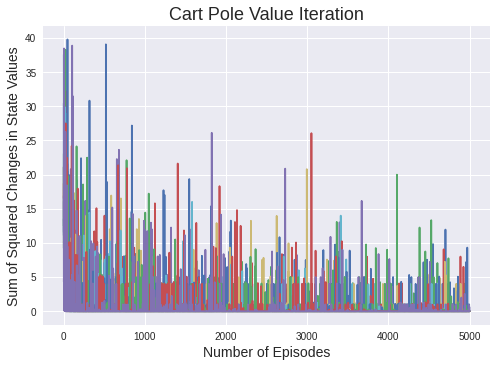

In [14]:
plt.style.use('seaborn')
plt.figure()
plt.title('Cart Pole Value Iteration', fontsize = 18)
plt.xlabel("Number of Episodes", fontsize=14)
plt.ylabel("Sum of Squared Changes in State Values", fontsize=14)
for record in delta_record:
    plt.plot(record)
plt.savefig("CartPole_VI.png")

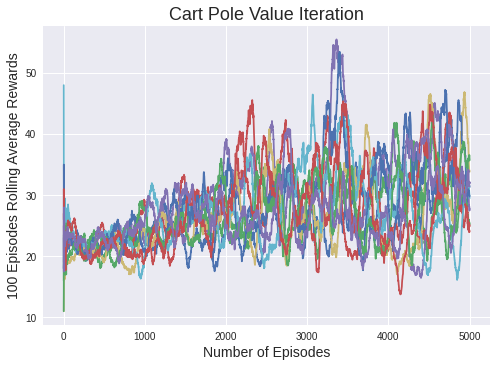

In [15]:
plt.style.use('seaborn')
plt.figure()
plt.title('Cart Pole Value Iteration', fontsize = 18)
plt.xlabel("Number of Episodes", fontsize=14)
plt.ylabel("100 Episodes Rolling Average Rewards", fontsize=14)
for record in rewards_record:
    plt.plot(record)
plt.savefig("Cartpole_VI_rewards.png")